In [1]:
import gc
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import pickle
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBRegressor

In [2]:
data_path = './kaggle/input/geolifeclef-2024'
output_path = './kaggle/working'

# Load the PA metadata for the training set
pa_metadata_train_csv_filename = data_path + '/GLC24_PA_metadata_train.csv'
pa_metadata_train_df = pd.read_csv(pa_metadata_train_csv_filename)

# Get information about each survey for plotting locations, including the number
# of each species found in each survey
pa_survey_metadata_train_df = (pa_metadata_train_df
                               .copy()
                               .drop_duplicates('surveyId'))
pa_survey_metadata_train_df.drop('speciesId', axis=1, inplace=True)
pa_survey_metadata_train_df['speciesCount'] = (pa_metadata_train_df
                                        .groupby('surveyId')
                                        .count()
                                        .speciesId
                                        .tolist())

In [3]:
pa_survey_metadata_train_df.head()

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,surveyId,speciesCount
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,212,16
16,9.884560,56.912140,2017,10.0,79.0,CONTINENTAL,Denmark,222,5
21,8.256020,55.637050,2019,10.0,79.0,ATLANTIC,Denmark,243,14
35,-0.402590,43.505630,2018,1.0,NaN,ATLANTIC,France,324,6
41,-0.517360,45.806430,2017,1.0,NaN,ATLANTIC,France,333,9


In [4]:
pa_survey_metadata_train_df = pd.merge(pa_survey_metadata_train_df,
                                       pd.get_dummies(pa_survey_metadata_train_df[['region', 'country']], dtype='int'),
                                       how='left',
                                       left_index=True,
                                       right_index=True)

In [5]:
pa_survey_metadata_train_df.head()

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,surveyId,speciesCount,region_ALPINE,...,country_Norway,country_Poland,country_Portugal,country_Romania,country_Serbia,country_Slovakia,country_Slovenia,country_Spain,country_Switzerland,country_The former Yugoslav Republic of Macedonia
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,212,16,0,...,0,0,0,0,0,0,0,0,0,0
16,9.884560,56.912140,2017,10.0,79.0,CONTINENTAL,Denmark,222,5,0,...,0,0,0,0,0,0,0,0,0,0
21,8.256020,55.637050,2019,10.0,79.0,ATLANTIC,Denmark,243,14,0,...,0,0,0,0,0,0,0,0,0,0
35,-0.402590,43.505630,2018,1.0,NaN,ATLANTIC,France,324,6,0,...,0,0,0,0,0,0,0,0,0,0
41,-0.517360,45.806430,2017,1.0,NaN,ATLANTIC,France,333,9,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = pa_survey_metadata_train_df.drop(['geoUncertaintyInM', 'areaInM2', 'region', 'country', 'surveyId', 'speciesCount'], axis=1)
y = pa_survey_metadata_train_df['speciesCount']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

In [7]:
%%time
n_species_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, early_stopping_rounds=10)
n_species_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:12.00777
[1]	validation_0-rmse:11.36581
[2]	validation_0-rmse:10.98829
[3]	validation_0-rmse:10.69679
[4]	validation_0-rmse:10.53217
[5]	validation_0-rmse:10.43110
[6]	validation_0-rmse:10.35391
[7]	validation_0-rmse:10.32969
[8]	validation_0-rmse:10.24080
[9]	validation_0-rmse:10.18832
[10]	validation_0-rmse:10.09085
[11]	validation_0-rmse:10.04068
[12]	validation_0-rmse:10.01498
[13]	validation_0-rmse:9.99744
[14]	validation_0-rmse:9.95998
[15]	validation_0-rmse:9.94264
[16]	validation_0-rmse:9.92394
[17]	validation_0-rmse:9.88387
[18]	validation_0-rmse:9.86505
[19]	validation_0-rmse:9.86070
[20]	validation_0-rmse:9.84052
[21]	validation_0-rmse:9.83600
[22]	validation_0-rmse:9.83171
[23]	validation_0-rmse:9.81312
[24]	validation_0-rmse:9.78082
[25]	validation_0-rmse:9.78050
[26]	validation_0-rmse:9.76048
[27]	validation_0-rmse:9.72660
[28]	validation_0-rmse:9.71240
[29]	validation_0-rmse:9.70730
[30]	validation_0-rmse:9.69192
[31]	validation_0-rmse:9.68651
[32]	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
with open("n_species_model.pkl", 'wb') as file:
    pickle.dump(n_species_model, file)

In [9]:
with open("n_species_model.pkl", 'rb') as file:
    n_species_model = pickle.load(file)

In [10]:
val_predict = n_species_model.predict(X_val)
val_raw_resid = val_predict - y_val
val_norm_resid = (val_raw_resid - val_raw_resid.mean())/val_raw_resid.std()

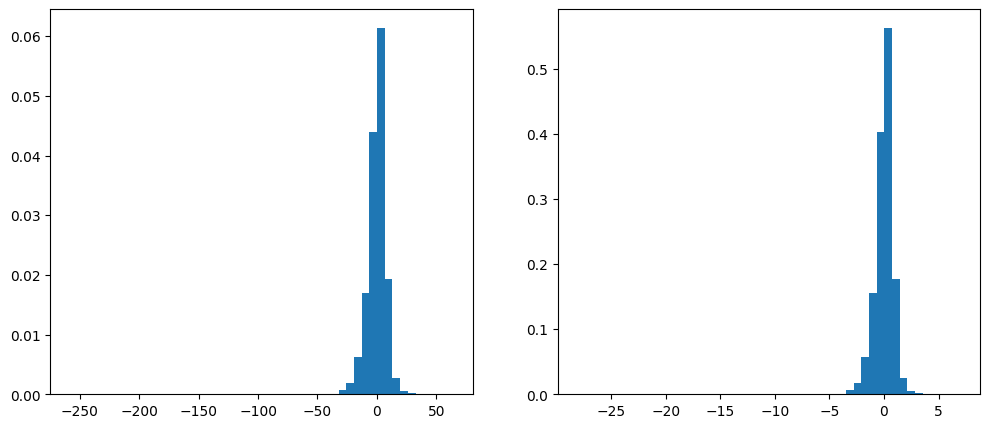

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(val_raw_resid, bins=50, density=True)

ax2.hist(val_norm_resid, bins=50, density=True)

plt.show()

In [19]:
t_params = stats.jf_skew_t.fit(val_norm_resid)
transformed_resid = stats.t.cdf(val_norm_resid, t_params[0], t_params[1], t_params[2])

AttributeError: module 'scipy.stats' has no attribute 'jf_skew_t'

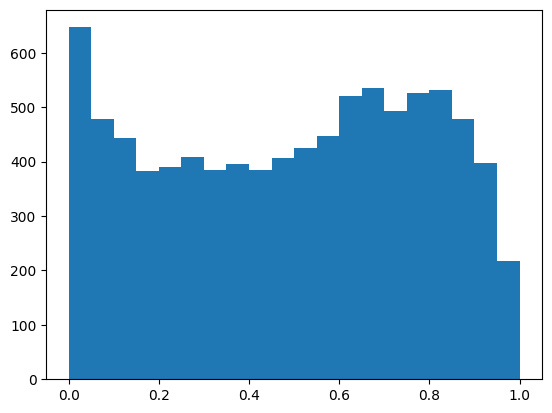

In [13]:
fig, ax = plt.subplots()
ax.hist(transformed_resid, bins=20)
plt.show()

In [16]:
# Apply GOF tests to the transformed residuals
stats.goodness_of_fit(stats.uniform, transformed_resid, known_params={'loc': 0, 'scale': 1}, statistic='ks')

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0, scale=1)
 success: True
 message: 'The fit was performed successfully.', statistic=0.03271250376363988, pvalue=0.0001, null_distribution=array([0.00615604, 0.00748478, 0.01259303, ..., 0.0076456 , 0.00901487,
       0.00993589]))

In [17]:
stats.goodness_of_fit(stats.uniform, transformed_resid, known_params={'loc': 0, 'scale': 1}, statistic='ad')

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0, scale=1)
 success: True
 message: 'The fit was performed successfully.', statistic=29.721584272809196, pvalue=0.0001, null_distribution=array([1.34644392, 0.45626753, 0.63193422, ..., 1.42362675, 0.52303724,
       0.39160114]))

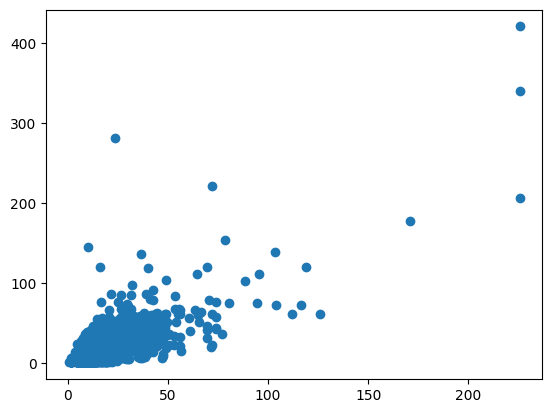

In [28]:
fig, ax = plt.subplots()

ax.scatter(val_predict, y_val)

plt.show()

array([-258.47021866, -195.4140625 , -149.09854126, ...,   49.76761627,
         51.55215454,   64.8592453 ])